In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timedelta
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

    
plt.style.use("bmh")
from IPython.core.debugger import set_trace

In [2]:
# Reading files
df = pd.read_csv("DATA/eventos6h.csv",parse_dates=["start","duration"])

df.dropna(how="any", axis=0,inplace=True)

# Drop any empty line
df.dropna(axis=1,inplace=True)

# Parsing column to timedelta
df.duration = df.duration.apply(pd.to_timedelta)

In [3]:
df.head()

,start,station,duration,Pluviometro,RADAR,ERROR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364
2,2016-10-14 07:20:00,MB_ANHA1,05:40:00,12.00,5.553790,6.446210
3,2016-10-20 16:00:00,MB_ANHA1,05:10:00,21.00,3.895931,17.104069
4,2016-10-21 00:40:00,MB_ANHA1,00:10:00,0.25,0.000000,0.250000
5,2016-10-23 14:40:00,MB_ANHA1,03:00:00,21.25,4.680203,16.569797


In [4]:
# Define the intensity pairs 
# 0 min to 9 min
# 10 min to 19 ...
# 
pairs= [(0,10),(10,20),(20,30),(30,40),(40,50),(50,60)]

In [5]:
def plot_function(radar_par,pluvi_par,f,par,save = False):
    """
    Create a scatter plot between the radar and the diference (radar - gauge) data.
    
    Args:
        radar_par Radar data with intensity between the par.
        pluvi_par Gauge data with intensity between the par.
        f: it should be a function between the difference and radar. Use the np.poly1d(np.polyfit(x,y,d))
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
        par: pair with the intensity limits.
        save: bool save the plot, the directory is harded coded in the function, my bad.

    """
    
    diff = pluvi_par - radar_par
    r2 = f"R2: {round(r2_score(diff, f(radar_par)),4)}"
    name = f"IMAGENS/cdf2/function-{par}.png"

    plt.figure()
    plt.title("Range " + str(par))
    plt.scatter(radar_par, diff)
    x = np.linspace(par[0],par[1])
    y_pred = f(x)
    plt.plot(x, y_pred,"lightblue")
    plt.ylabel("Difference Gauge - Radar (mm)")
    plt.xlabel("Radar (mm)")
    x = .8 * (plt.xlim()[1] - plt.xlim()[0]) + plt.xlim()[0]
    y = .15 * (plt.ylim()[1] - plt.ylim()[0]) + plt.ylim()[0]
    plt.grid(False)
    plt.annotate(r2,(x,y))
    if save:
        plt.savefig(name)
    plt.show()

In [6]:
df[["RADAR","Pluviometro"]]

,RADAR,Pluviometro
1,0.214636,0.2500
2,5.553790,12.0000
3,3.895931,21.0000
4,0.000000,0.2500
5,4.680203,21.2500
...,...,...
7646,3.581209,2.7500
7647,0.581985,1.2500
7648,0.023392,0.1250
7649,0.012722,0.1250


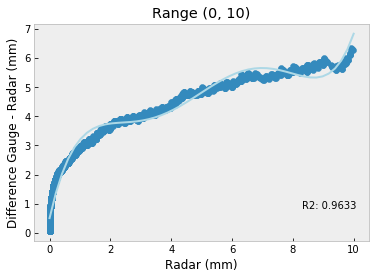

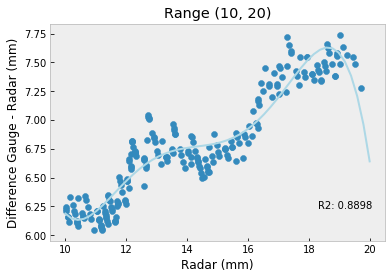

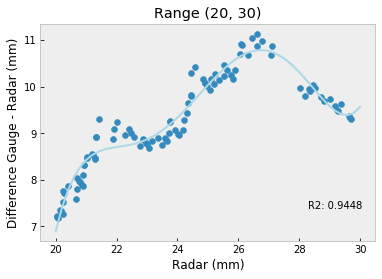

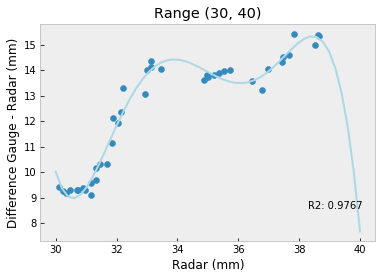

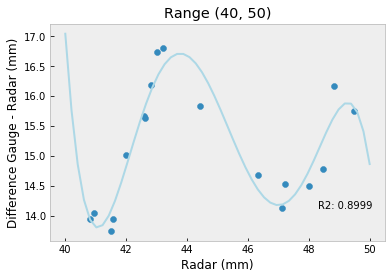

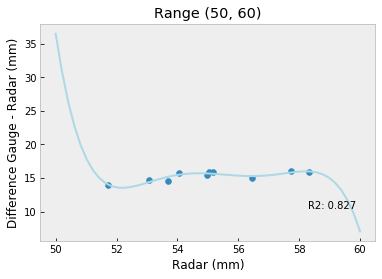

In [7]:
# store the function from each pair
functions = {}
radar = df.RADAR.sort_values().values
pluvi = df.Pluviometro.sort_values().values

for par in pairs:
        
    cond1 = np.where(radar >= par[0])
    cond2 = np.where(radar < par[1])
    start = cond1[0][0]
    end = cond2[0][-1]
    radar_par = radar[start:end]
    pluvi_par = pluvi[start:end]
    diff = pluvi_par - radar_par
    
    
    f = np.poly1d(np.polyfit(radar_par, diff, 5))
    functions[par[1]] = f
    plot_function(radar_par,pluvi_par,f,par,save=True)

In [8]:
functions

{10: poly1d([ 2.62426584e-03, -6.70333306e-02,  6.17071202e-01, -2.49155680e+00,
         4.63200482e+00,  5.06677363e-01]),
 20: poly1d([-8.32682900e-04,  6.00960100e-02, -1.71211858e+00,  2.40622654e+01,
        -1.66648150e+02,  4.60870136e+02]),
 30: poly1d([ 1.95630064e-03, -2.45408259e-01,  1.22473804e+01, -3.03994803e+02,
         3.75372724e+03, -1.84436133e+04]),
 40: poly1d([-7.27444561e-03,  1.26359493e+00, -8.75927624e+01,  3.02876836e+03,
        -5.22364915e+04,  3.59474954e+05]),
 50: poly1d([-5.55584837e-03,  1.25791155e+00, -1.13742087e+02,  5.13412967e+03,
        -1.15686147e+05,  1.04101431e+06]),
 60: poly1d([-1.09822675e-02,  3.04154679e+00, -3.36761295e+02,  1.86329944e+04,
        -5.15197174e+05,  5.69486215e+06])}

In [7]:
# Explanation for the correction function below.
## for each event in the df
serie = df.loc[24]
serie

start          2016-11-30 13:30:00
station                   MB_ANHA1
duration           0 days 05:20:00
Pluviometro                  85.75
RADAR                      11.4427
ERROR                      74.3073
Name: 24, dtype: object

In [10]:
# I discover the pair
serie["RADAR"] >= 10 and serie["RADAR"] < 20

True

In [11]:

# I use the function stored in the dictionary "functions"
# to calculate the correction
functions[20](serie["RADAR"])

6.3175920338408105

In [12]:
# if the error is positive i`ll sume the bias correction
# if the error is negative i`ll subtrair the bias.
serie["RADAR"] - functions[20](serie["RADAR"]) if serie["ERROR"] < 0 else functions[20](serie["RADAR"]) + serie["RADAR"]

17.760338483840812

In [13]:
def correction(serie):

    for par in pairs:
        if serie["RADAR"] >= par[0] and serie["RADAR"] < par[1]:
            new_serie = serie.copy()
            y = functions[par[1]](serie["RADAR"])
            corr = serie["RADAR"] - y if serie["ERROR"] < 0 else serie["RADAR"] + y
            new_serie["CORREC_RADAR"] = corr
            return new_serie

In [14]:
correction(serie)

start           2016-11-30 13:30:00
station                    MB_ANHA1
duration            0 days 05:20:00
Pluviometro                   85.75
RADAR                       11.4427
ERROR                       74.3073
CORREC_RADAR                17.7603
Name: 24, dtype: object

In [15]:
# Applyng the correction for each event (line) of the df
df_n = df.apply(correction,axis=1)

In [16]:
# It`s can create values below 0, 
any(df_n.CORREC_RADAR < 0)

True

In [17]:
# All values below 0 it`ll be equal to zero.
df_n.CORREC_RADAR[df_n.CORREC_RADAR < 0] = 0

/home/nardo/miniconda3/envs/ic/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
any(df_n.CORREC_RADAR < 0)

False

In [19]:
df_n.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364,1.606688
2,2016-10-14 07:20:00,MB_ANHA1,05:40:00,12.00,5.553790,6.446210,10.732988
3,2016-10-20 16:00:00,MB_ANHA1,05:10:00,21.00,3.895931,17.104069,8.032881
4,2016-10-21 00:40:00,MB_ANHA1,00:10:00,0.25,0.000000,0.250000,0.506677
5,2016-10-23 14:40:00,MB_ANHA1,03:00:00,21.25,4.680203,16.569797,9.280267


In [20]:
df_n["ERROR_CORR"] = df.Pluviometro - df_n.CORREC_RADAR

In [21]:
df_n.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364,1.606688,-1.356688
2,2016-10-14 07:20:00,MB_ANHA1,05:40:00,12.00,5.553790,6.446210,10.732988,1.267012
3,2016-10-20 16:00:00,MB_ANHA1,05:10:00,21.00,3.895931,17.104069,8.032881,12.967119
4,2016-10-21 00:40:00,MB_ANHA1,00:10:00,0.25,0.000000,0.250000,0.506677,-0.256677
5,2016-10-23 14:40:00,MB_ANHA1,03:00:00,21.25,4.680203,16.569797,9.280267,11.969733


In [22]:
df_n.describe()

,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
count,5306,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000
mean,0 days 03:07:35.936675,4.962881,2.576625,2.386256,3.397439,1.565442
std,0 days 08:42:48.428985,9.204515,6.436539,7.856901,6.422036,6.624361
min,0 days 00:10:00,0.062500,0.000000,-49.929871,0.000000,-35.544697
25%,0 days 00:30:00,0.375000,0.000000,0.125000,0.506677,-0.444177
50%,0 days 02:10:00,1.687500,0.120081,0.739996,0.801314,0.035562
75%,0 days 05:00:00,4.937500,1.552348,2.743137,3.652606,1.764970
max,18 days 06:20:00,85.750000,59.883186,81.304868,73.583001,78.613757


In [23]:
pearsonr(df_n.Pluviometro.values,df_n.RADAR.values)

ValueError: array must not contain infs or NaNs

In [24]:
pearsonr(df_n.Pluviometro.values,df_n.CORREC_RADAR.values)

ValueError: array must not contain infs or NaNs

In [25]:
# print the correlation coefficient for the values with and with out the correction for each pair
for par in pairs:
    df_20 = df_n.query("RADAR >= @par[0] & RADAR < @par[1]")
    print(par)
    print(pearsonr(df_20.Pluviometro.values,df_20.RADAR.values)[0] ** 2)
    print(pearsonr(df_20.Pluviometro.values,df_20.CORREC_RADAR.values)[0] ** 2)
    print()

(0, 10)
0.13603244327593644
0.2558169827818177

(10, 20)
0.022183741228697988
0.5200408778278343

(20, 30)
0.013872474213373471
0.6766722291177143

(30, 40)
0.002905812357751477
0.6826831162822401

(40, 50)
0.0019205974786341996
0.5130184469941351

(50, 60)
0.005377450734694553
0.9094962352190433



In [68]:
df_n.sort_values("RADAR",inplace=True)

In [69]:
df_n.dropna(axis=0,how="all",inplace=True)

In [70]:
df_n.tail()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
7288,2017-10-22 05:40:00,MB_SEG6,0 days 06:00:00,7.9375,55.157268,-47.219768,39.505028,-31.567528
7136,2016-12-08 12:00:00,MB_SEG6,0 days 03:30:00,69.7500,56.452724,13.297276,71.755671,-2.005671
2256,2016-05-10 20:20:00,MB_COQ2,0 days 05:30:00,78.5000,57.743004,20.756996,73.583001,4.916999
7310,2017-11-30 12:00:00,MB_SEG6,0 days 05:20:00,10.2500,58.316076,-48.066076,42.314147,-32.064147
4205,2016-02-29 00:10:00,MB_LAJ7,0 days 06:00:00,54.0000,59.883186,-5.883186,51.237084,2.762916


In [103]:
par = pairs[1]
radar = df_n.RADAR.values
pluvi = df_n.Pluviometro.values
corr_radar = df_n.CORREC_RADAR.values
cond1 = np.where(radar >= par[0])
cond2 = np.where(radar < par[1])
start = cond1[0][0]
end = cond2[0][-1]
radar_par=radar[start:end]
pluvi_par = pluvi[start:end]
corr_par = corr_radar[start:end]

In [107]:
def plot_scatter(ax, y, x, ylabel):
    x_ = np.arange(0,80)
    f = np.poly1d(np.polyfit(x,y,1))
    y_ = f(x_)
    
    ax.set_title(f"{ylabel} x GAUGE")
    ax.scatter(x,y)
    ax.set_ylim(0,80)
    ax.set_xlim(0,80)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("GAUGE")
    ax.plot(x_,y_,"lightblue")
    r2 = f"R2: {round(pearsonr(x,y)[0]**2,3)}"
    ax.annotate(r2,(65,10))
    ax.grid(False)
    ;

In [108]:
def plot_figure(radar_par,pluvi_par,corr_par,save=False,name=None):
    
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

    plot_scatter(ax1,radar_par,pluvi_par,"RADAR")
    plot_scatter(ax2,corr_par,pluvi_par,"CORRECTED RADAR")

    if save and name:
        name = f"IMAGENS/cdf2/Distribution-{name}.png"
        plt.savefig(name)
    plt.show();

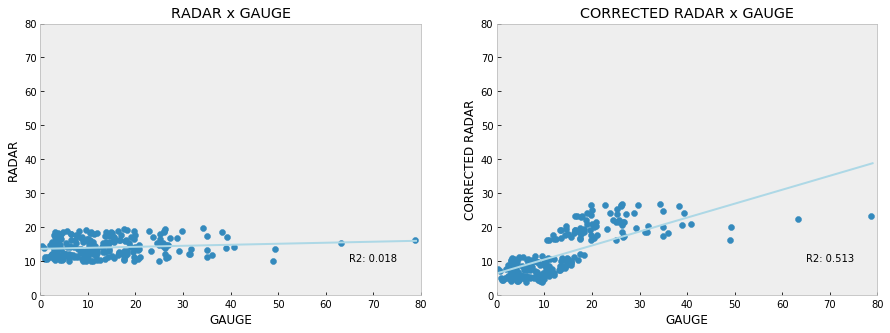

In [109]:
plot_figure(radar_par,pluvi_par,corr_par)

In [111]:
def plot_cdf(radar_par, pluvi_par, corr_par,save=False,name=None):
    
    cdf = np.arange(len(radar_par)) / len(radar_par)
    
    radar_sort = radar_par.copy()
    radar_sort.sort()
    pluvi_sort = pluvi_par.copy()
    pluvi_sort.sort()
    corr_sort = corr_par.copy()
    corr_sort.sort()

    plt.figure()
    plt.plot(radar_sort, cdf,color="green",label="RADAR")
    plt.plot(pluvi_sort, cdf,color="darkblue",label="Gauge")
    plt.plot(corr_sort, cdf,color="blue",label="Correcter Radar")
    plt.legend()
    plt.grid(False)
    if save and name:
        name = f"IMAGENS/cdf2/cdf-{name}.png"
        plt.savefig(name)
    plt.show();

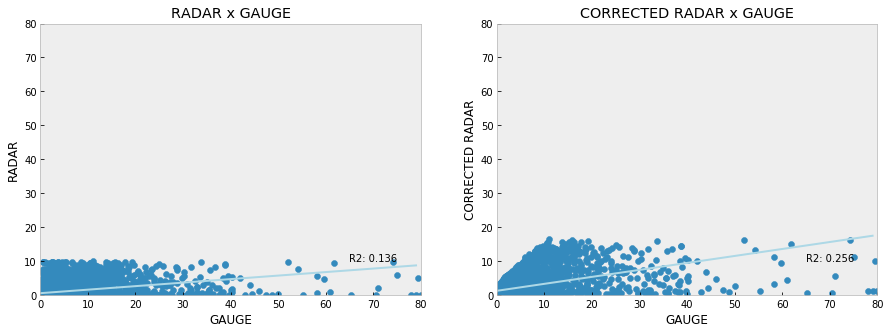

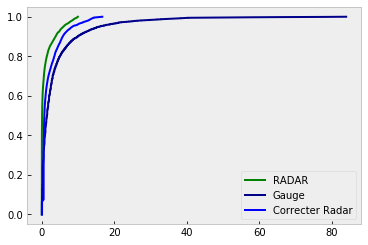

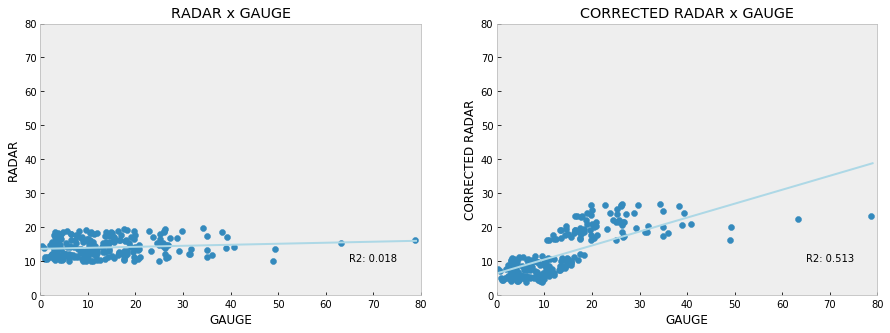

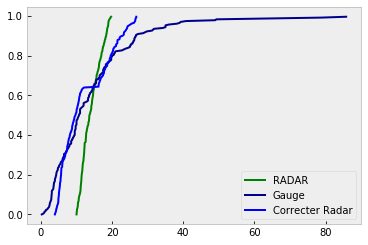

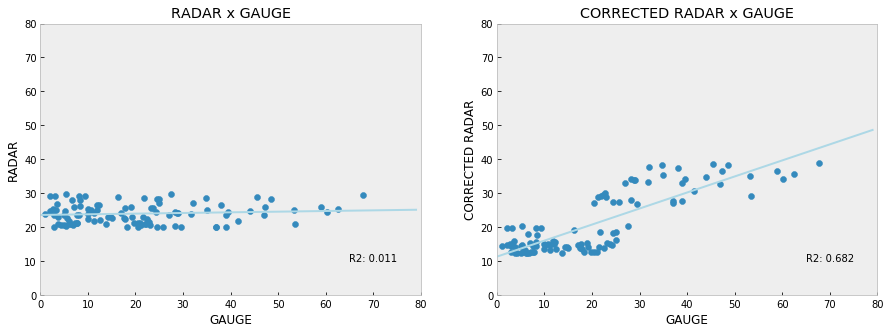

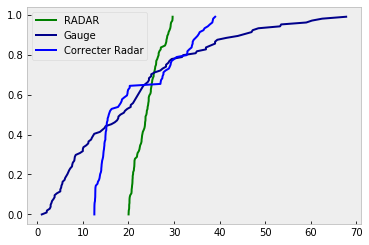

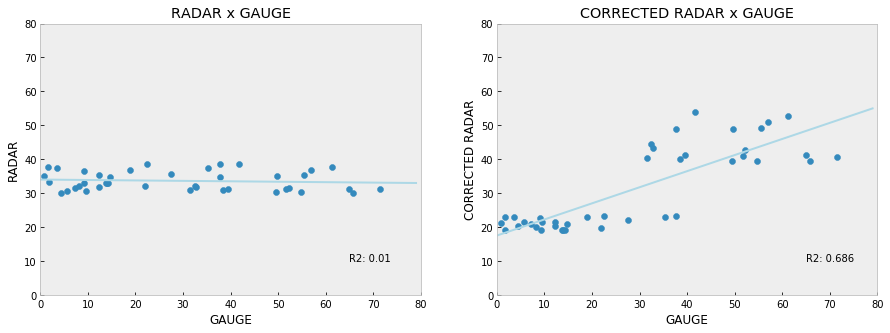

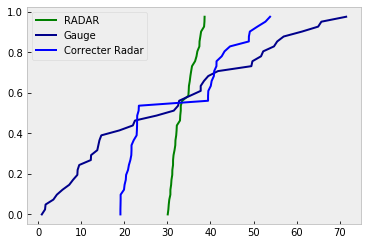

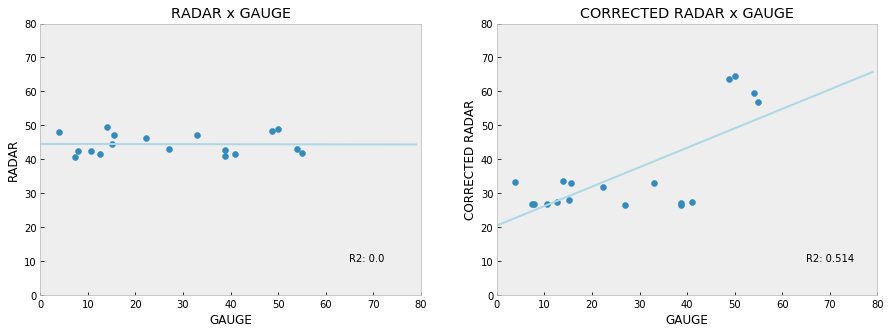

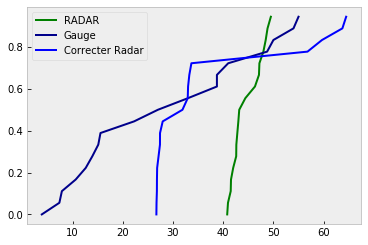

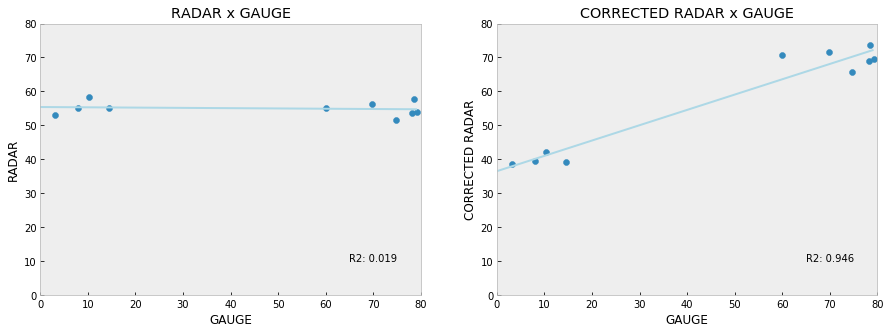

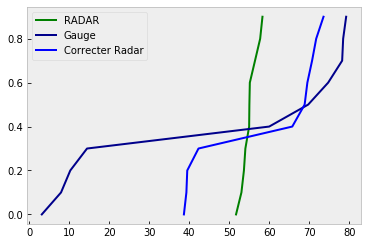

In [112]:
# Printing the graph for each pair
par = pairs[1]
radar = df_n.RADAR.values
pluvi = df_n.Pluviometro.values
corr_radar = df_n.CORREC_RADAR.values
for par in pairs:

    cond1 = np.where(radar >= par[0])
    cond2 = np.where(radar < par[1])
    start = cond1[0][0]
    end = cond2[0][-1]
    radar_par=radar[start:end]
    pluvi_par = pluvi[start:end]
    corr_par = corr_radar[start:end]
    
    
    plot_figure(radar_par,pluvi_par,corr_par,save=True,name=str(par))
    plot_cdf(radar_par,pluvi_par,corr_par,save=True, name=str(par))

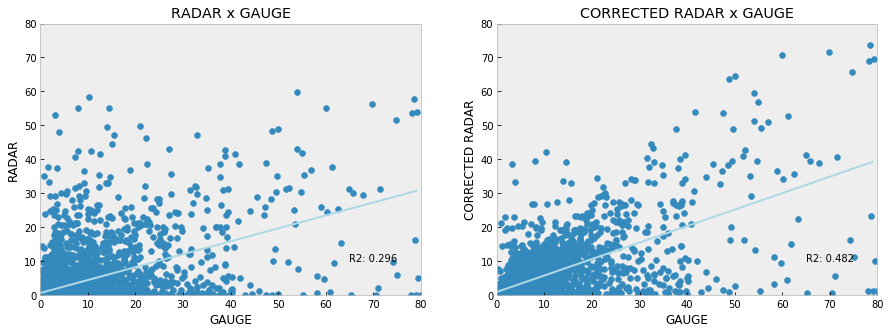

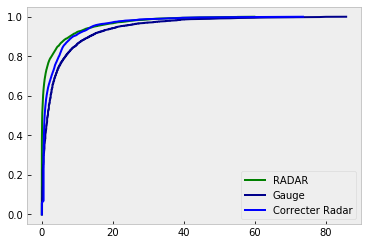

In [113]:
# Comparison  for all the data
radar = df_n.RADAR.values
pluvi = df_n.Pluviometro.values
corr = df_n.CORREC_RADAR.values
plot_figure(radar,pluvi,corr,save=True,name="All")
plot_cdf(radar,pluvi,corr,save=True,name="All")

In [114]:
df_5 = df_n[df_n.RADAR >= 5]

In [115]:
df_5.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
3242,2018-01-02 14:20:00,MB_IMB5,0 days 02:20:00,1.500,5.002160,-3.502160,0.184008,1.315992
1081,2017-01-12 14:10:00,MB_BAL1,0 days 02:40:00,3.000,5.006591,-2.006591,0.185423,2.814577
2873,2016-02-26 11:30:00,MB_GAM1,0 days 05:40:00,8.250,5.008026,3.241974,9.830171,-1.580171
5808,2017-03-14 14:20:00,MB_PRO6,0 days 02:50:00,0.625,5.022975,-4.397975,0.190656,0.434344
7067,2016-05-12 20:10:00,MB_SEG6,0 days 03:00:00,9.750,5.029364,4.720636,9.866030,-0.116030


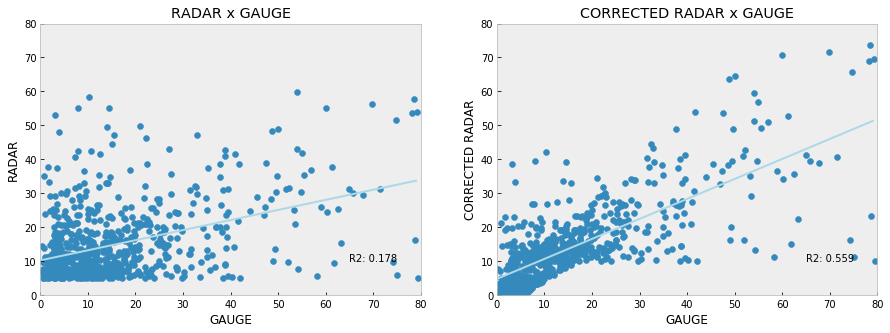

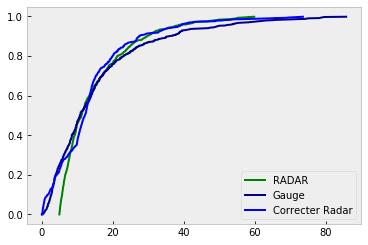

In [116]:
radar = df_5.RADAR.values
pluvi = df_5.Pluviometro.values
corr = df_5.CORREC_RADAR.values
plot_figure(radar,pluvi,corr,save=True,name="All-above5")
plot_cdf(radar,pluvi,corr,save=True,name="All-above5")

In [117]:
df_10 = df_n[df_n.RADAR >= 10]

In [118]:
df_10.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
6402,2017-01-25 11:30:00,MB_SEG3,0 days 06:00:00,49.0000,10.007369,38.992631,16.193674,32.806326
4568,2016-02-02 13:30:00,MB_PRO1,0 days 02:30:00,11.0000,10.020240,0.979760,16.202984,-5.202984
3141,2017-03-05 14:20:00,MB_IMB3,0 days 04:50:00,25.0000,10.037694,14.962306,16.215829,8.784171
5167,2017-01-18 17:20:00,MB_PRO3,0 days 02:40:00,6.0625,10.090164,-4.027664,3.924380,2.138120
115,2017-01-18 17:40:00,MB_ANHA3,0 days 01:40:00,10.6250,10.094398,0.530602,16.259280,-5.634280


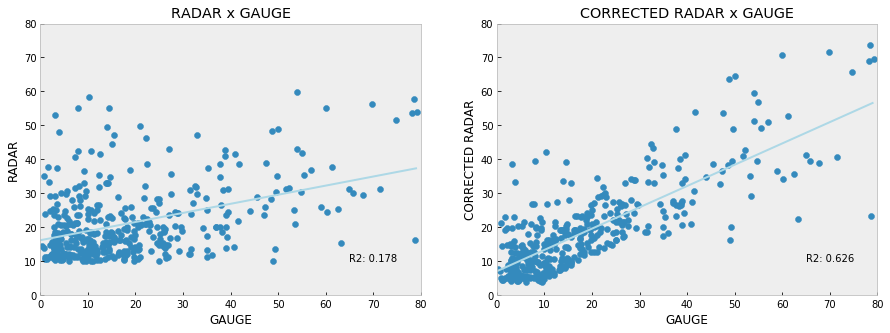

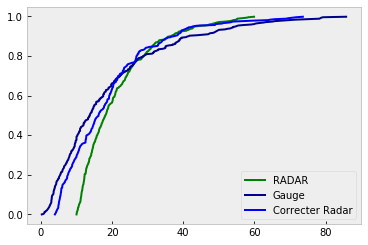

In [119]:
radar = df_10.RADAR.values
pluvi = df_10.Pluviometro.values
corr = df_10.CORREC_RADAR.values
plot_figure(radar,pluvi,corr,save=True,name="All-above10")
plot_cdf(radar,pluvi,corr,save=True,name="All-above10")

In [90]:
df_10.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CORREC_RADAR,ERROR_CORR
6402,2017-01-25 11:30:00,MB_SEG3,0 days 06:00:00,49.0000,10.007369,38.992631,16.193674,32.806326
4568,2016-02-02 13:30:00,MB_PRO1,0 days 02:30:00,11.0000,10.020240,0.979760,16.202984,-5.202984
3141,2017-03-05 14:20:00,MB_IMB3,0 days 04:50:00,25.0000,10.037694,14.962306,16.215829,8.784171
5167,2017-01-18 17:20:00,MB_PRO3,0 days 02:40:00,6.0625,10.090164,-4.027664,3.924380,2.138120
115,2017-01-18 17:40:00,MB_ANHA3,0 days 01:40:00,10.6250,10.094398,0.530602,16.259280,-5.634280


In [91]:
df_10.to_csv("DATA/eventos-above10.csv",index=False)